In [1]:
!pip install tensorflow tensorflow-datasets matplotlib numpy pandas


In [2]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf

(ds_train, ds_test), ds_info = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

print(ds_info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.P9DBG6_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='/root/tensorflow_datasets/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Im

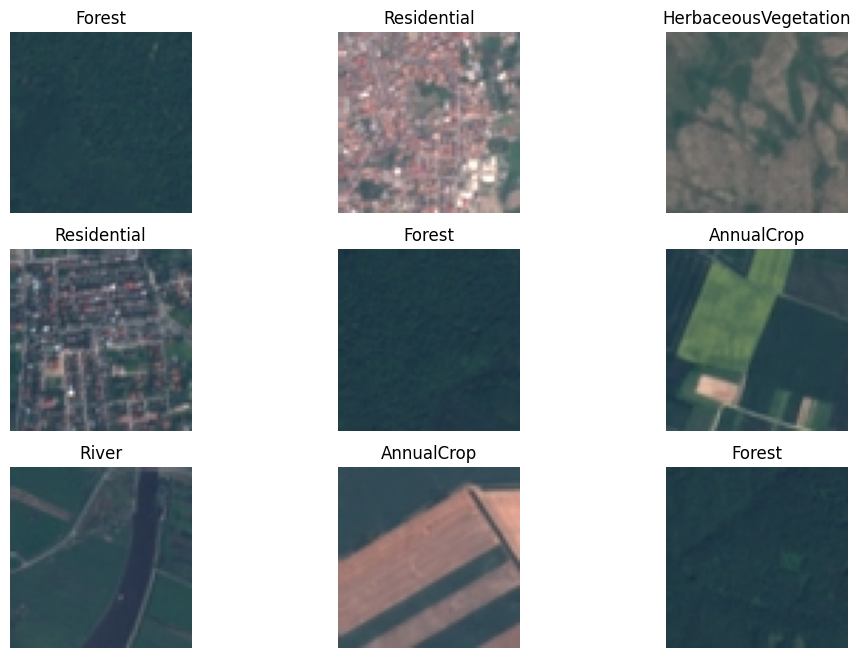

In [5]:
import matplotlib.pyplot as plt

class_names = ds_info.features['label'].names

plt.figure(figsize=(12,8))

# Take a batch of 9 images from the dataset
for image_batch, label_batch in ds_train.batch(9).take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = image_batch[i].numpy()
        label = label_batch[i].numpy()
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis("off")




In [6]:
def preprocess(image, label):
    image = tf.image.resize(image, (64,64)) / 255.0
    return image, label

train_ds = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(64,64,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,154 (399.04 KB)

 Trainable params: 102,154 (399.04 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds
)


Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 168s 245ms/step - accuracy: 0.3535 - loss: 1.6837 - val_accuracy: 0.5633 - val_loss: 1.1606
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 187s 223ms/step - accuracy: 0.5619 - loss: 1.1539 - val_accuracy: 0.6691 - val_loss: 0.8715
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 201s 221ms/step - accuracy: 0.6704 - loss: 0.8998 - val_accuracy: 0.7124 - val_loss: 0.7653
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 202s 220ms/step - accuracy: 0.7138 - loss: 0.7976 - val_accuracy: 0.7396 - val_loss: 0.7077
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 203s 222ms/step - accuracy: 0.7261 - loss: 0.7554 - val_accuracy: 0.7357 - val_loss: 0.6989
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 201s 221ms/step - accuracy: 0.7390 - loss: 0.7070 - val_accuracy: 0.7526 - val_loss: 0.6587
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 202s 221ms/step - accuracy: 0.7524 - loss: 0.6731 - val_accuracy: 0.7872 - val_loss: 0.5750
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 150s 222ms/step - accuracy: 0.7619 -

In [9]:
land_value_map = {
    'AnnualCrop': 500,
    'Forest': 300,
    'HerbaceousVegetation': 350,
    'Highway': 800,
    'Industrial': 1000,
    'Pasture': 400,
    'PermanentCrop': 450,
    'Residential': 900,
    'River': 200,
    'SeaLake': 150
}

def predict_land_value(image_batch):
    preds = model.predict(image_batch)
    predicted_labels = np.argmax(preds, axis=1)
    predicted_classes = [class_names[i] for i in predicted_labels]
    predicted_values = [land_value_map[cls] for cls in predicted_classes]
    return predicted_classes, predicted_values

# Test prediction on a batch
for images, labels in test_ds.take(1):
    classes, values = predict_land_value(images)
    for cls, val in zip(classes[:5], values[:5]):
        print(f"Land use: {cls}, Predicted land value: ${val}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Land use: Pasture, Predicted land value: $400
Land use: Residential, Predicted land value: $900
Land use: AnnualCrop, Predicted land value: $500
Land use: Forest, Predicted land value: $300
Land use: AnnualCrop, Predicted land value: $500


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


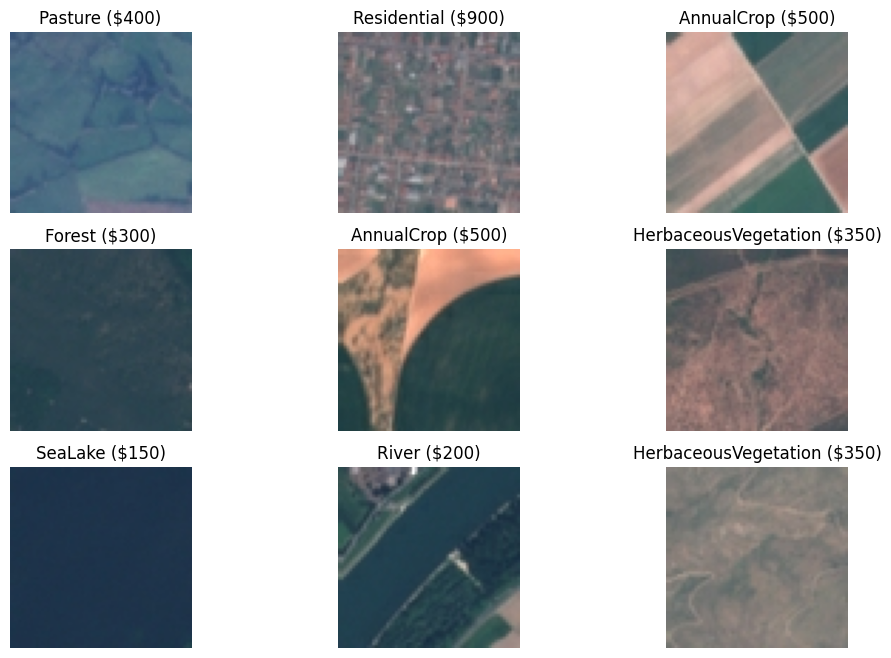

In [10]:
plt.figure(figsize=(12,8))
for images, labels in test_ds.take(1):
    predicted_classes, predicted_values = predict_land_value(images)
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"{predicted_classes[i]} (${predicted_values[i]})")
        plt.axis("off")


In [17]:
!pip install opencv-python
!pip install gradio



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.5 MB/s eta 0:00:00


In [18]:
import cv2
from PIL import Image
import io

def predict_land_value_from_image(img):
    # Resize and normalize for model
    resized_img = tf.image.resize(img, (64, 64)) / 255.0
    input_tensor = tf.expand_dims(resized_img, axis=0)

    # Predict
    preds = model.predict(input_tensor)
    class_index = np.argmax(preds[0])
    confidence = preds[0][class_index] * 100
    land_use_type = class_names[class_index]
    land_value = land_value_map[land_use_type]

    # Annotate image with prediction
    display_img = np.array(img).astype(np.uint8).copy()
    display_img = cv2.resize(display_img, (256, 256))  # upscale for better visibility

    label_text = f"{land_use_type} (${land_value}) - {confidence:.1f}%"
    cv2.putText(display_img, label_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.rectangle(display_img, (5, 5), (250, 40), (0, 0, 0), thickness=-1)  # label background
    cv2.putText(display_img, label_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)

    annotated_img = Image.fromarray(display_img)

    return annotated_img, f"Land Use: {land_use_type}", f"Estimated Value: ${land_value}", f"Confidence: {confidence:.1f}%"


In [19]:
import gradio as gr

gr.Interface(
    fn=predict_land_value_from_image,
    inputs=gr.Image(type="numpy", label="Upload Satellite Image"),
    outputs=[
        gr.Image(label="Annotated Image"),
        gr.Text(label="Land Type"),
        gr.Text(label="Estimated Land Value"),
        gr.Text(label="Confidence")
    ],
    title="🌍 Land Use & Value Predictor",
    description="Upload a satellite-style image to predict land use type, estimated value, and confidence. Based on EuroSAT and simulated pricing."
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c692e4bba676139e92.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
